In [26]:
import requests
import os
from PIL import Image
import math
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from owslib.wms import WebMapService


def latlong_to_xy(lat, lon, zoom):
    '''
    Converts latitude and longitude to tile coordinates
    '''
    lonRad = math.radians(lon)
    latRad = math.radians(lat)
    columnIndex = lonRad
    rowIndex = math.log(math.tan(latRad) + (1.0 / math.cos(latRad)))
    columnNormalized = (1 + (columnIndex / math.pi)) / 2
    rowNormalized = (1 - (rowIndex / math.pi)) / 2
    tilesPerRow = 2 ** zoom
    column = round(columnNormalized * (tilesPerRow - 1))
    row = round(rowNormalized * (tilesPerRow - 1))
    
    # ' -1' takes a square in the middle of a 3x3 grid
    return [column - 1, row - 1]


def download_tile(x, y, z): 
    '''
    Downloads a tile for the given x and y coordinates and zoom level. 
    It is pretty slow as it downloads one tile at a time
    '''
    url = "https://khms.google.com/kh/v=908?x=" + str(x) + "&y=" + str(y) + "&z=" + str(z)
    response = requests.get(url)
    bytes_io = BytesIO(response.content)
    PIL_image = Image.open(bytes_io)
    return PIL_image


def dl_square(x, y, z, size=3): 
    '''
    Downloads a square of tiles, might add other shapes later
    '''
    imgs = {}
    max_x = x + size - 1
    max_y = y + size - 1
    y2 = y
    
    while x <= max_x:
        while y <= max_y:
            imgs[f"{x}_{y}"] = download_tile(x, y, z)
            y += 1
        y = y2
        x += 1
    
    return imgs


def stitch_tiles(imgs, x, y, size=3):
    '''
    Stitches tiles into one large image
    '''
    
    # Stitched image size
    width = size * 256
    height = size * 256
    
    max_x = x + size - 1
    max_y = y + size - 1
    x2 = x
    y2 = y
    
    output = Image.new(mode = "RGB", size = (width, height))
    
    while x2 <= max_x:
        while y2 <= max_y:
            img = imgs[f"{x2}_{y2}"]
            position_x = (x2 - x) * 256
            position_y = (y2 - y) * 256
            output.paste(img, (position_x, position_y))
            y2 += 1

        y2 = y
        x2 += 1

    return output


def calculate_zoom(lat: float):
    '''
    Defines the zoom level closest to 10 meters per pixel
    156543.03392 * Math.cos(latLng.lat() * Math.PI / 180) / Math.pow(2, zoom)
    '''
    meters_per_pixel = 10
    zoom = round(math.log(156543.03392 * math.cos(lat * math.pi / 180) / meters_per_pixel, 2), 0)
    return int(zoom)

def calc_meters_per_pixel(lat, zoom):
    '''
    Calculates how many meters are represented in one pixel
    '''
    return (156543.03392 * math.cos(lat * math.pi / 180) / (2 ** zoom))

def image_resize(meters_per_pixel, img):
    '''
    Resizes image to adjust the ratio to 10 meters per pixel
    '''
    pixels = img.height
    total_meters = meters_per_pixel*pixels
    new_size = int(round(total_meters/10,0))
    new_size = (new_size, new_size)
    return img.resize(new_size)

def image_crop(img):
    '''
    Crops the image to adjust size multiple of 64 pixels
    '''
    crop_pix = int(img.height / 64) * 64
    return img.crop((0,0,crop_pix,crop_pix))


    
def split_tiles(img : Image):
    """
    Given a big image, crop it into small images (tiles) of 64x64 pixels
    """
    
    tiles = []
    quads = int(img.height/64)
    
    for i in range(quads):
        for j in range(quads):
            temp_tile = np.array(img.crop((i*64, j*64, i*64+64, j*64+64)))
            tiles.append(temp_tile)
    
    return np.array(tiles)
    
def address_to_coord(address):
    '''
    Returns the latitude and longitude for a given address
    '''
    url = 'https://nominatim.openstreetmap.org/search'
    #'q' is for query --> look at hte documentation
    params = {'q': address, 'format': 'json'}
    response = requests.get(url, params = params).json()

    lat = float(response[0]['lat'])
    longi = float(response[0]['lon'])
    return lat, longi


def plot_image_categories(img, classes):
    '''
    Plot the images with the quadrants and correspondent classes
    '''
    xs = range(64, img.height, 64)
    xt = range(20, img.height, 64)
    yt = range(44, img.height, 64)
    plt.imshow(img)
    # multiple lines all full height
    plt.vlines(x=xs, ymin=0, ymax=img.height-1, colors='red', ls='-', lw=0.5)
    plt.hlines(y=xs, xmin=0, xmax=img.height-1, colors='red', ls='-', lw=0.5)
    for item_x,value_x in enumerate(xt):
        for item_y,value_y in enumerate(yt):
            plt.text(value_x, value_y, classes[item_x, item_y], color = 'red')
    plt.show()
    
def plot_sub_images_categories(img, classes):
    '''
    Plot the images with the quadrants and correspondent classes
    '''
    
    quads = int(img.height/64)
    fig, axs = plt.subplots(quads, quads, figsize = (10, 10))
    for i in range(quads):
        for j in range(quads):
            img_quad = img.crop((i*64, j*64, i*64+64, j*64+64))
            axs[j, i].imshow(img_quad)
            axs[j, i].text(22, 40, classes[i, j], color = 'red')
            axs[j, i].axis('off')
    plt.show()


def plot_classified_images(X_new, y_pred_class):
    """
    Plot a grid of tiles contained in X_new with its correspondent predicted classes
    """
    size = int(X_new.shape[0] ** 0.5)    
    X_reshaped = X_new.reshape((size,size,64,64,3))
    fig, axs = plt.subplots(size, size, figsize = (10, 10))
    for i in range(size) :
        for j in range(size) :
            axs[j, i].imshow(X_reshaped[i,j])
            axs[j, i].text(22, 40, y_pred_class[i, j], color = 'red')
            axs[j, i].axis('off')
    plt.show()


In [72]:
# lat = float(input("Enter latitude:"))
# longi = float(input("Enter longitude:"))
# zoom = int(input("Enter zoom level:"))
# size_deg = float(input("Enter size in longitute degrees:"))

# Grenoble
# address = '29 avenue de la monta, saint egreve'
address = '6831 Mojave Sage Ct, Las Vegas'

# # Singapore
# address = '101 Thomson Rd, Singapore 307591'

#lat, longi = address_to_coord(address)

lat, longi = (36.063030, -115.314929)

zoom = calculate_zoom(lat)
size = 3
coords = latlong_to_xy(lat, longi, zoom)
imgs = dl_square(coords[0], coords[1], zoom)
stitched_image = stitch_tiles(imgs, coords[0], coords[1])
meters_per_pixel = calc_meters_per_pixel(lat, zoom)
meters_per_pixel

7.723674052100625

(768, 768)

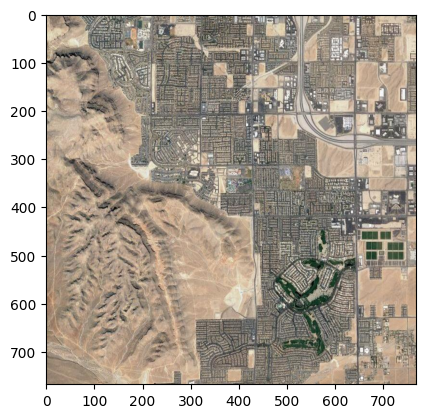

In [73]:
plt.imshow(stitched_image);
stitched_image.size

(593, 593)

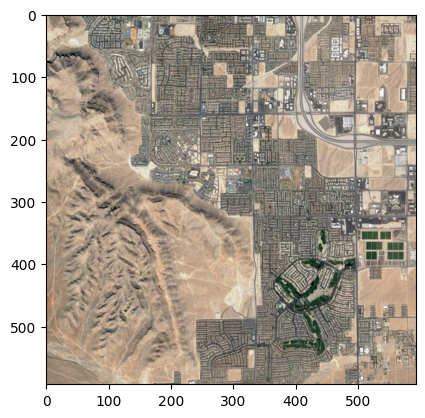

In [74]:
img = image_resize(meters_per_pixel, stitched_image)
plt.imshow(img);
img.size

(576, 576)

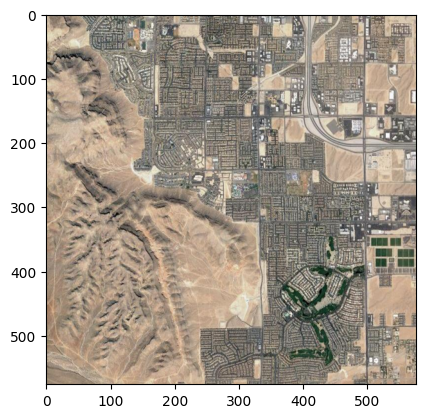

In [75]:
img = image_crop(img)
plt.imshow(img);
img.size

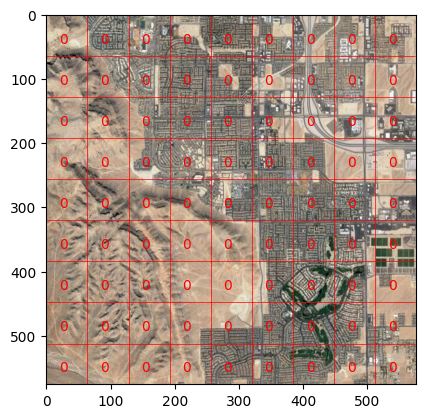

In [76]:
quadrants = int(img.height/64)
categories = np.zeros((quadrants, quadrants), dtype=int)
plot_image_categories(img, categories)

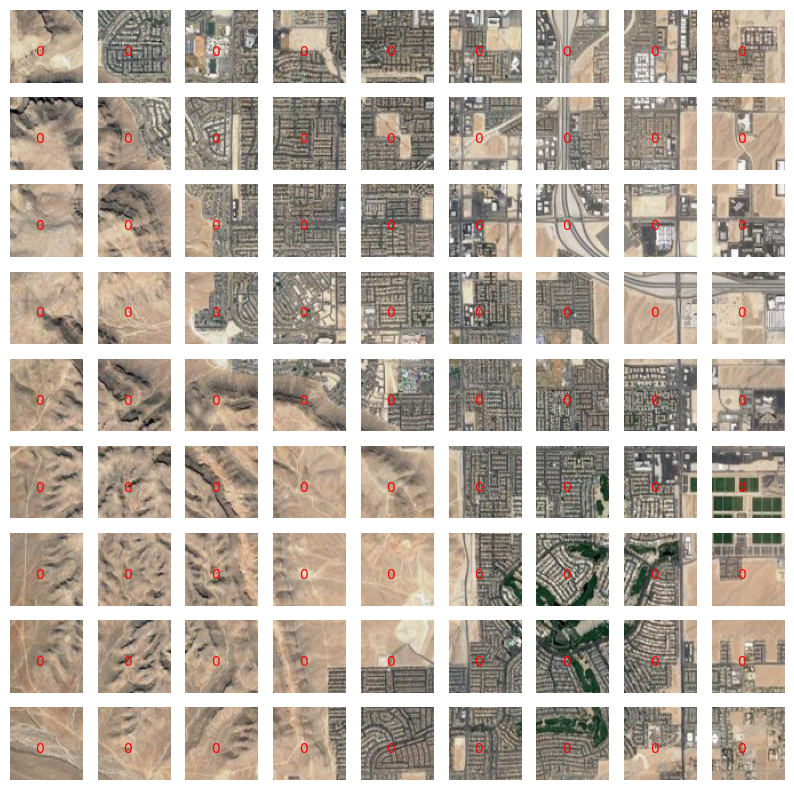

In [77]:
plot_sub_images_categories(img, categories)

In [78]:
X_new = split_tiles(img)

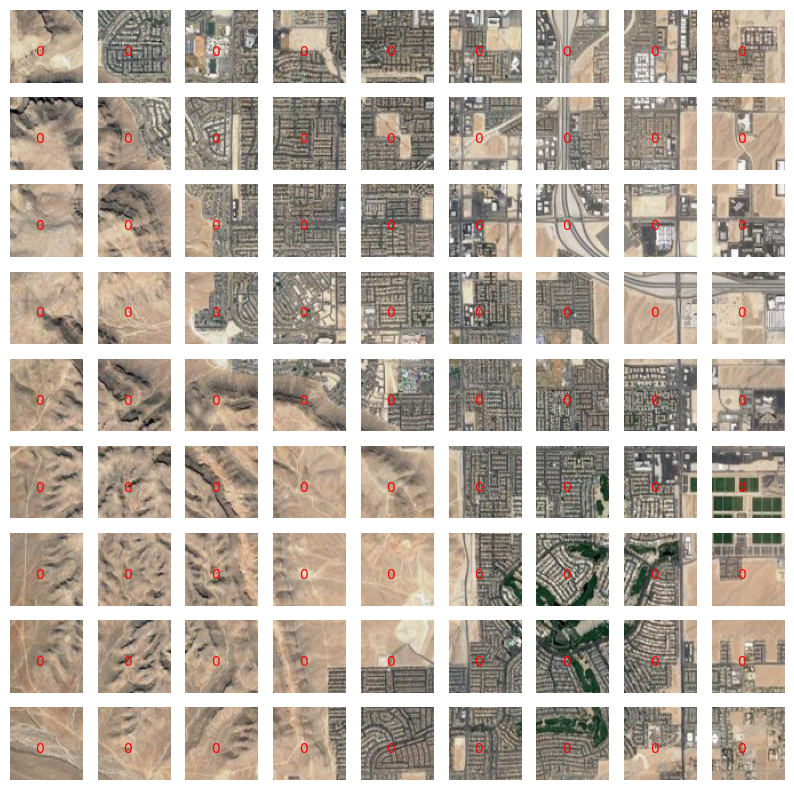

In [79]:
plot_classified_images(X_new, categories)

In [80]:
def get_s2maps_data(size_km:float, lat:float, lon:float, year:str) -> np.ndarray:
    """
    Given the image side size in km and a GPS coordinate, retuns an RGB image centered
    in the given point with resolution of 10m/pixel

    Arguments:
        size_km: size of the image side in km (float)
        lat: latitude of the central point (float)
        lon: longitude of the central point (float)
        year: year of historical data, 4 options among [2017,2018,2019,2020]

    Returns:
        An RGB image stured in a numpy.array

    """
    url = 'https://tiles.maps.eox.at/wms?service=wms&request=getcapabilities'
    wms = WebMapService(url)

    bbox = get_bounding_box(lat, lon, size_km/2)

    # Get new image
    pixels = int(size_km * 100)

    response = wms.getmap(
        layers=[f"s2cloudless-{year}"],
        size=[pixels, pixels],
        srs="EPSG:4326",
        #Bounding box for map extent. Value is minx,miny,maxx,maxy in units of the SRS. Left, bottom, right, top
        bbox=[bbox.lon_min, bbox.lat_min, bbox.lon_max, bbox.lat_max],
        format="image/jpeg")

    bytes_io = BytesIO(response.read())
    PIL_image = Image.open(bytes_io)
    return PIL_image


class BoundingBox(object):
    def __init__(self, *args, **kwargs):
        self.lat_min = None
        self.lon_min = None
        self.lat_max = None
        self.lon_max = None


def get_bounding_box(latitude_in_degrees, longitude_in_degrees, half_side_in_km):
    assert half_side_in_km > 0
    assert latitude_in_degrees >= -90.0 and latitude_in_degrees  <= 90.0
    assert longitude_in_degrees >= -180.0 and longitude_in_degrees <= 180.0

    lat = math.radians(latitude_in_degrees)
    lon = math.radians(longitude_in_degrees)

    radius  = 6371
    # Radius of the parallel at given latitude
    parallel_radius = radius*math.cos(lat)

    lat_min = lat - half_side_in_km/radius
    lat_max = lat + half_side_in_km/radius
    lon_min = lon - half_side_in_km/parallel_radius
    lon_max = lon + half_side_in_km/parallel_radius
    rad2deg = math.degrees

    box = BoundingBox()
    box.lat_min = rad2deg(lat_min)
    box.lon_min = rad2deg(lon_min)
    box.lat_max = rad2deg(lat_max)
    box.lon_max = rad2deg(lon_max)

    return (box)

(320, 320)

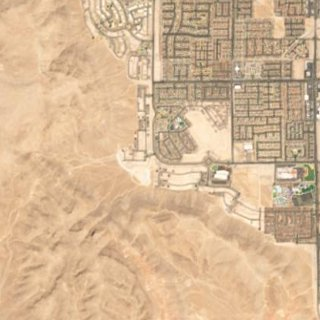

In [87]:
img_pablo = get_s2maps_data(3.2, lat, longi, '2018')
display(img_pablo.size)
img_pablo

(320, 320)

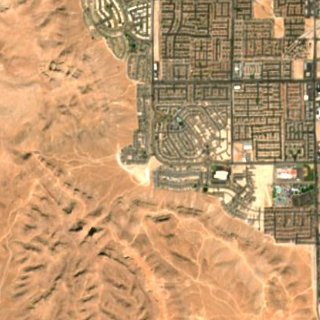

In [85]:
img_pablo = get_s2maps_data(3.2, lat, longi, '2020')
display(img_pablo.size)
img_pablo

(576, 576)

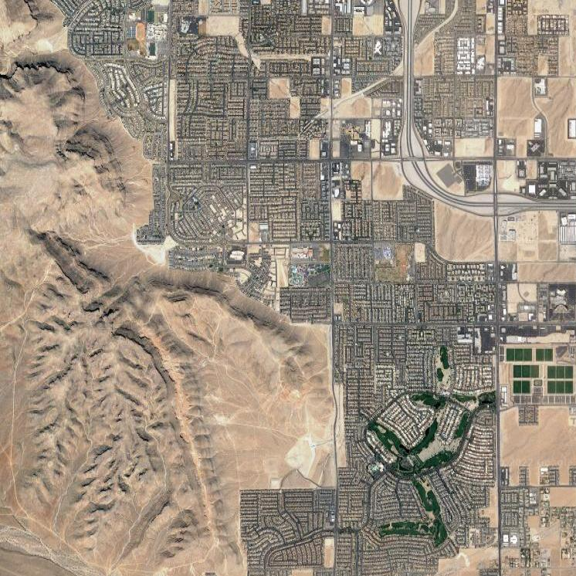

In [83]:
display(img.size)
img